In [4]:
# the purpose of this notebook is to test and time alternative lung masking techniques
import os                                   # do directory ops
import math                                 # used for ceil ops
import datetime                             # used for saving with a datetime string
import pandas as pd                         # data analysis
import numpy as np                          # array ops
import matplotlib.pyplot as plt             # used for visualization in dev
import pydicom                              # for reading dicom files
from cv2 import resize, threshold, THRESH_OTSU           # image processing
from skimage import morphology, measure     # for lung masking
from skimage.transform import rescale, resize
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans          # for lung masking
from tqdm import tqdm                       # for progress bars
import seaborn as sns
import cv2
from importlib import reload

import sys
# import current lungmask technique
sys.path.insert(1, '/Users/jesse/Documents/osic_kaggle/scripts/submission_scripts')
import pre_proc
from random import choice

In [2]:
# new method using otsu's thresholding
def make_lungmask_v2(img):

    mid_dict = {}

    row_size= img.shape[0]
    col_size = img.shape[1]

    # Rescale pixels to 255
    img = img.astype(float)
    #### need to get middle portion and normalize to it
    # Find the average pixel value near the lungs to renormalize washed out images.
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    im_mean = np.mean(middle)  
    im_max = np.max(img)
    im_min = np.min(img)
    # To improve threshold finding, I'm moving the underflow and overflow on the pixel spectrum
    img[img==im_max]=im_mean
    img[img==im_min]=im_mean

    im_min = np.min(img) # many are not windowed and have vals < 0
    if im_min < 0:
        img = img - im_min
    img = (np.maximum(img,0) / img.max()) * 255.0

    # EXPERIMENTAL
    img = gaussian_filter(img, sigma=1)

    # otsu's binarization thresholding
    thresh, thresh_img = threshold(img.astype('uint8'), np.min(img), np.max(img), THRESH_OTSU)
    # rescale to binary and invert
    thresh_img = np.where(thresh_img==0,1,0)

    mid_dict['thresholded'] = thresh_img

    ###########################################

    # now copy functionality from the old method to achieve a mask

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.
    erosion = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(erosion,np.ones([13,13]))

    mid_dict['morph'] = dilation

    labels = measure.label(dilation) # Different labels are displayed in different colors
    labels = labels + 1 # add 1 to every element so that the background is no longer encoded as 0
    regions = measure.regionprops(labels) # for some reason ignores labels marked 0
    good_labels = []
    n_px = len(img.flatten())
    for prop in regions:
        B = prop.bbox # (min_row, min_col, max_row, max_col)
        # region width < 90% of img
        # region height < 90% of img
        # min row > 15%, max row < 85%
        # min col < 15%, max col < 85%
        # region area is > 0.1% of img
        if B[2]-B[0]<row_size*.80 and \
            B[3]-B[1]<col_size*.80 and \
            B[0]>row_size*.05 and B[2]<row_size*.95 and \
            B[1]>col_size*.05 and B[3]<col_size*.95 and \
            prop.area/n_px*100 > 0.1:
            good_labels.append(prop.label) 
            #print(f'prop {prop.label} area: {np.round(prop.area/n_px*100,2)}, {B}')
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([5,5])) # one last dilation

    # final masked image
    masked_img = mask*img
    mask_var = np.round(np.var(mask), 4)
    n_labels = len(good_labels)

    return masked_img, mask_var, n_labels, mid_dict

### List of patient: problem
- ID00248637202266698862378: has circular border causing major issue


In [8]:
def find_interior_ind(arr):
    border_val = arr[0]
    borderless_start_ind = np.where(arr!=border_val)[0][0]
    borderless_end_ind = np.where(arr!=border_val)[0][-1]
    return borderless_start_ind+5, borderless_end_ind-5

def custom_trim(im):
    mid_inds = np.array(im.shape) // 2
    middle_row = im[mid_inds[0],:]
    middle_col = im[:,mid_inds[1]]
    left, right = find_interior_ind(middle_row)
    top, bot = find_interior_ind(middle_col)
    return im[top:bot, left:right]

In [9]:
def valid_mask(mask_var, n_labels):
    # evaluates a single CT slice to assess if the masking did a good job
    if mask_var > .04 and n_labels < 10:
        return True
    return False

In [79]:
# prepare random patient folder of images for processing
dicom_dir = "/Users/jesse/Documents/osic_kaggle/data/train/"
patients = os.listdir(dicom_dir) # list of training patient IDS (folders which contain DICOMS)
patient = choice(patients)
patient = 'ID00032637202181710233084'
path = dicom_dir + patient
dicoms = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
dicoms.sort(key=lambda x: int(x.ImagePositionPatient[2]))

print(f'Patient: {patient}; n CTs: {len(dicoms)}')

Patient: ID00032637202181710233084; n CTs: 205


In [39]:
%%time

slices = [dicom.pixel_array for dicom in dicoms]

# V2; OTSU'S BINARIZATION FOR THRESHOLDING
new_mask_results = []
for ct_scan in tqdm(slices):
    new_mask_results.append(make_lungmask_v2(pre_proc.custom_trim(ct_scan)))

100%|██████████| 205/205 [00:05<00:00, 38.91it/s]CPU times: user 5.02 s, sys: 385 ms, total: 5.4 s
Wall time: 5.39 s



In [82]:
%%time

reload(pre_proc)

slices = []
manually_thresholded_slices = []

for dicom in tqdm(dicoms):

    # grab information from dicoms for later
    img = dicom.pixel_array.copy()
    rescale_intercept = dicom.RescaleIntercept
    rescale_slope = dicom.RescaleSlope

    # remove border if there is one
    img = pre_proc.custom_trim(img)

    # rescale HU
    hu_scaled_img = pre_proc.transform_to_hu(img=img, rescale_slope=rescale_slope, rescale_intercept=rescale_intercept)
    # window
    windowed_img = pre_proc.set_manual_window(hu_scaled_img)
    # mask slice
    masked_img, manually_thresholded = pre_proc.lung_mask(windowed_img)
    
    slices.append(masked_img)
    manually_thresholded_slices.append(manually_thresholded)
    


100%|██████████| 205/205 [00:07<00:00, 25.87it/s]CPU times: user 7.83 s, sys: 115 ms, total: 7.94 s
Wall time: 7.94 s



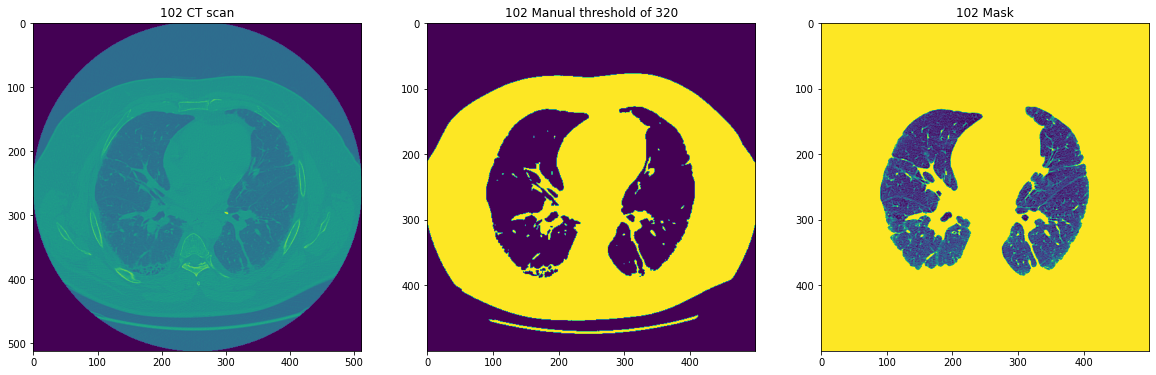

In [83]:
i = len(slices)//2
# i = 11

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20,40))
ax[0].imshow(dicoms[i].pixel_array);
ax[0].set_title(f'{i} CT scan');
ax[1].imshow(manually_thresholded_slices[i]);
ax[1].set_title(f'{i} Manual threshold of 320');
ax[-1].imshow(slices[i]);
ax[-1].set_title(f'{i} Mask');

<AxesSubplot:>

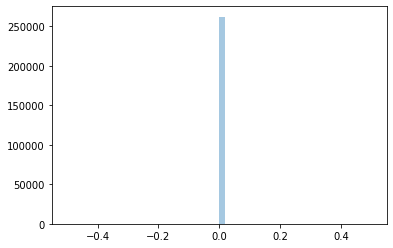

In [30]:
sns.distplot(slices[i].flatten(), kde=False)

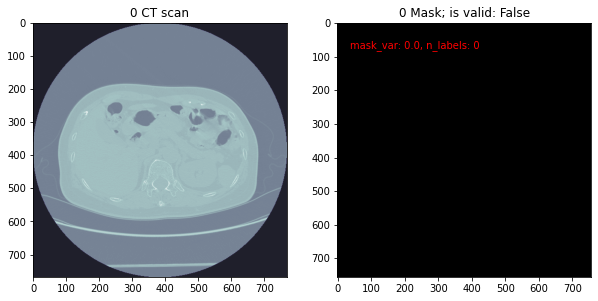

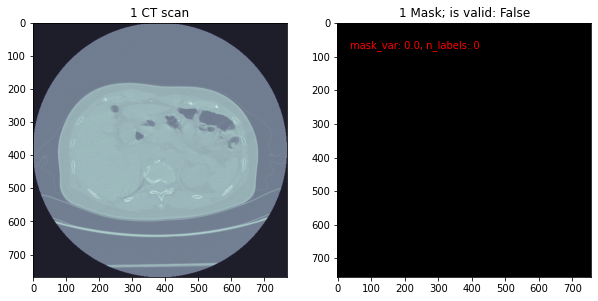

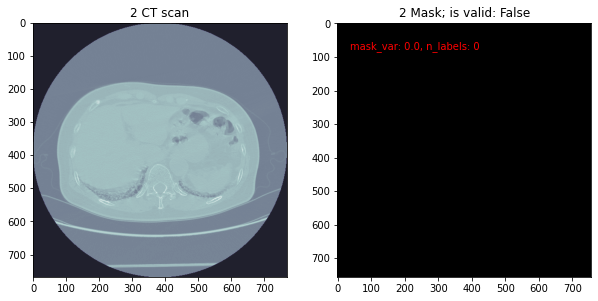

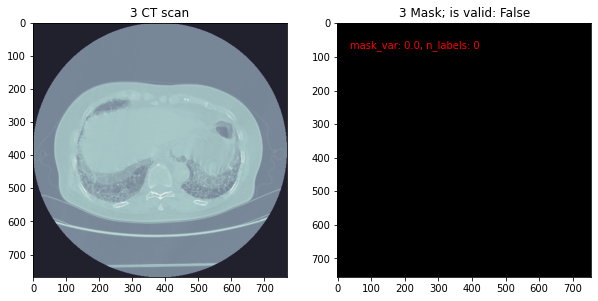

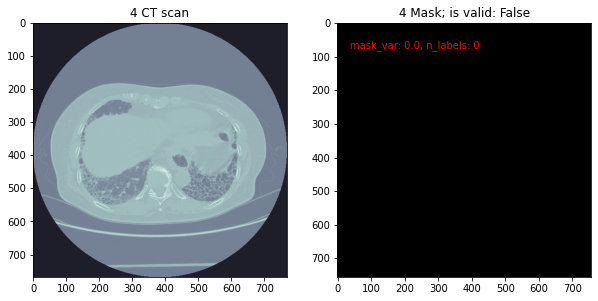

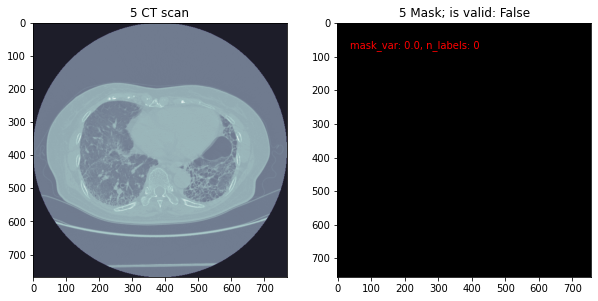

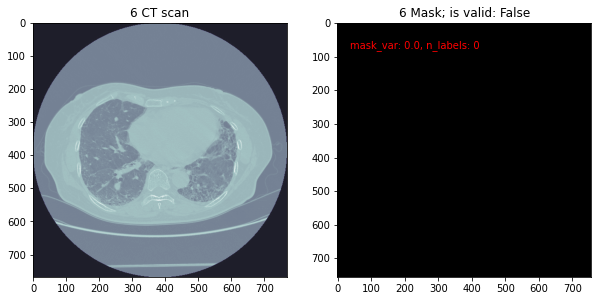

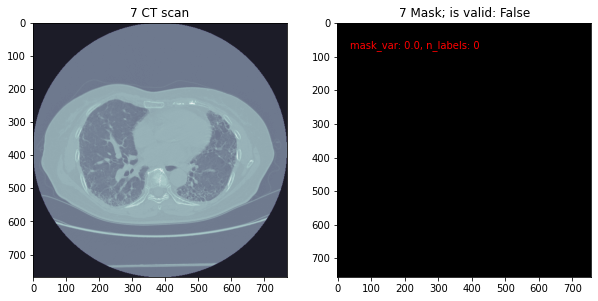

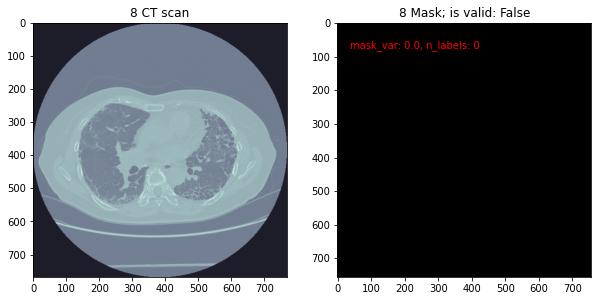

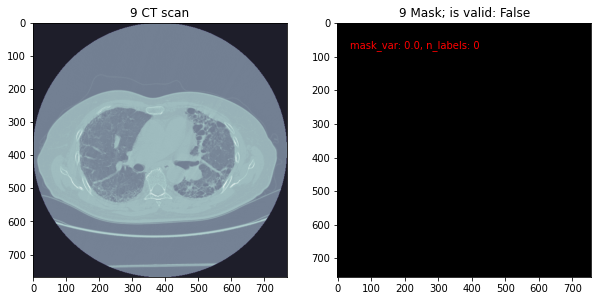

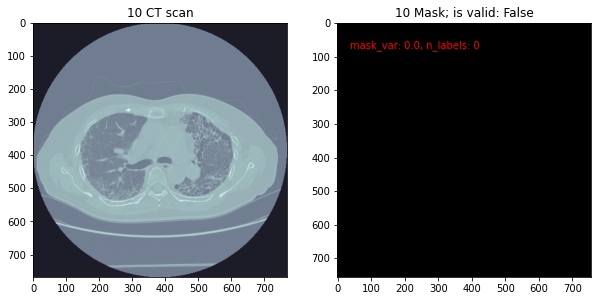

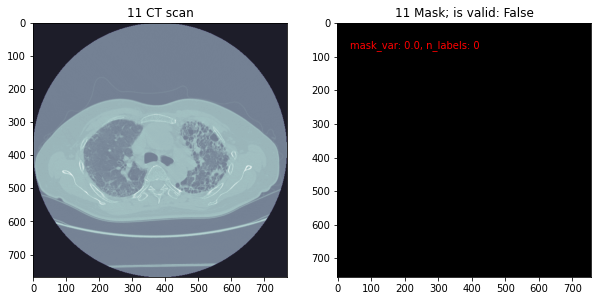

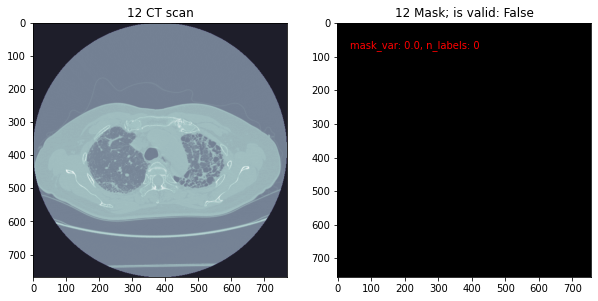

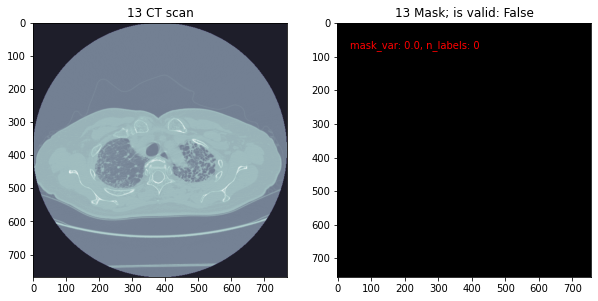

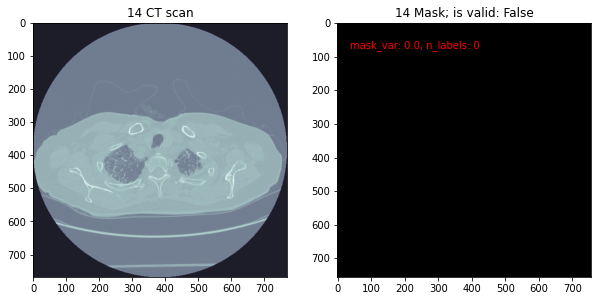

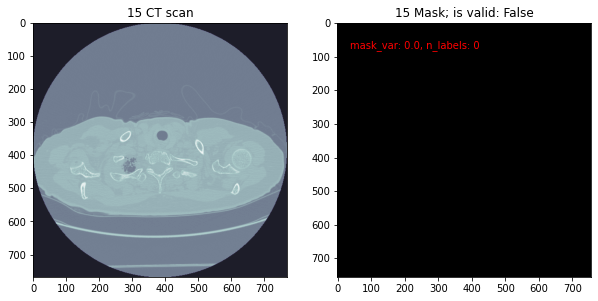

In [104]:
# View patient scan masks
N_SLICES = len(slices)
N_FIG_COLS = 2
N_FIG_ROWS = int(np.ceil(N_SLICES/N_FIG_COLS))

for i in range(N_SLICES)[:]:
    masked_img, mask_var, n_labels, _ = new_mask_results[i]
    fig, ax = plt.subplots(ncols=N_FIG_COLS, nrows=1, figsize=(10,20))
    ax[0].imshow(slices[i], cmap=plt.cm.bone)
    ax[0].set_title(f'{i} CT scan')
    ax[1].imshow(masked_img, cmap=plt.cm.bone)
    ax[1].set_title(f'{i} Mask; is valid: {valid_mask(mask_var, n_labels)}')
    c = 'g' if valid_mask(mask_var, n_labels) else 'r'
    plt.text(.05,.90,f'mask_var: {mask_var}, n_labels: {n_labels}', color = c, transform=ax[1].transAxes)
    plt.show()